## Constituency dataset validation


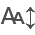

In [2]:
from policyengine_uk import Microsimulation
import pandas as pd
import h5py
import numpy as np
import sys
from itables import init_notebook_mode
import itables.options as opt
from pathlib import Path
from policyengine_uk_data.storage import STORAGE_FOLDER

opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

REPO = Path(".").resolve().parent

with h5py.File(STORAGE_FOLDER / "constituencies.h5", "r") as f:
    weights = f["2025"][:]

baseline = Microsimulation()
household_weights = baseline.calculate("household_weight", 2025).values

from policyengine_uk_data.datasets.frs.local_areas.constituencies.loss import create_constituency_target_matrix, create_national_target_matrix

constituency_target_matrix, constituency_actuals = create_constituency_target_matrix("enhanced_frs_2022_23", 2025, None)
national_target_matrix, national_actuals = create_national_target_matrix("enhanced_frs_2022_23", 2025, None)
constituencies_2024 = pd.read_csv(STORAGE_FOLDER / "constituencies_2024.csv")

constituency_wide = weights @ constituency_target_matrix
constituency_wide.index = constituencies_2024.code.values
constituency_wide["name"] = constituencies_2024.name.values

constituency_results = pd.melt(constituency_wide.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

constituency_actuals.index = constituencies_2024.code.values
constituency_actuals["name"] = constituencies_2024.name.values
constituency_actuals_long = pd.melt(constituency_actuals.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

constituency_target_validation = pd.merge(constituency_results, constituency_actuals_long, on=["index", "variable"], suffixes=("_target", "_actual"))
constituency_target_validation.drop("name_actual", axis=1, inplace=True)
constituency_target_validation.columns = ["index", "name", "metric", "estimate", "target"]

constituency_target_validation["error"] = constituency_target_validation["estimate"] - constituency_target_validation["target"]
constituency_target_validation["abs_error"] = constituency_target_validation["error"].abs()
constituency_target_validation["rel_abs_error"] = constituency_target_validation["abs_error"] / constituency_target_validation["target"]

### Calibration check
Looking at the sorted validation results by relative absolute error shows how well our calibrated weights perform against the actual target statistics across UK parliamentary constituencies under the new 2024 boundaries. The table reveals the accuracy of our estimates, from the closest matches to the largest discrepancies, where a lower relative error indicates better calibration performance.

In [3]:
constituency_target_validation.sort_values("rel_abs_error")

index                          name  \
11360  E14001373               New Forest East   
4325   E14001488          South Leicestershire   
821    E14001234            Farnham and Bordon   
2676   E14001139                    Broxbourne   
10790  E14001453                         Rugby   
...          ...                           ...   
6697   E14001260  Hackney South and Shoreditch   
7249   E14001162          Chesham and Amersham   
6599   E14001162          Chesham and Amersham   
7388   E14001301                  Ilford South   
6738   E14001301                  Ilford South   

                                          metric      estimate        target  \
11360  hmrc/employment_income/amount/30000_40000  2.509288e+08  2.509499e+08   
4325                                   age/40_50  1.193506e+04  1.193367e+04   
821                      hmrc/total_income/count  6.737637e+04  6.736803e+04   
2676                                   age/20_30  1.162183e+04  1.162016e+04   
10790   hmrc/employment_income/count/30000_40000  7.828644e+03  7.830460e+03   
...                                          ...           ...           ...   
6697    hmrc/employment_income/count/12570_15000  1.436137e+03  4.885362e+01   
7249   hmrc/employment_income/amount/12570_15000  1.991328e+07  6.456983e+05   
6599    hmrc/employment_income/count/12570_15000  1.435062e+03  4.649818e+01   
7388   hmrc/employment_income/amount/12570_15000  1.991574e+07  6.234373e+05   
6738    hmrc/employment_income/count/12570_15000  1.435239e+03  4.489512e+01   

              error     abs_error  rel_abs_error  
11360 -2.108173e+04  2.108173e+04       0.000084  
4325   1.389142e+00  1.389142e+00       0.000116  
821    8.340814e+00  8.340814e+00       0.000124  
2676   1.670008e+00  1.670008e+00       0.000144  
10790 -1.816220e+00  1.816220e+00       0.000232  
...             ...           ...            ...  
6697   1.387283e+03  1.387283e+03      28.396738  
7249   1.926758e+07  1.926758e+07      29.839914  
6599   1.388564e+03  1.388564e+03      29.862760  
7388   1.929230e+07  1.929230e+07      30.945050  
6738   1.390344e+03  1.390344e+03      30.968717  

[14300 rows x 8 columns]

In [10]:
national_performance = household_weights @ national_target_matrix
national_target_validation = pd.DataFrame({"metric": national_performance.index, "estimate": national_performance.values})
national_target_validation["target"] = national_actuals.values

national_target_validation["error"] = national_target_validation["estimate"] - national_target_validation["target"]
national_target_validation["abs_error"] = national_target_validation["error"].abs()
national_target_validation["rel_abs_error"] = national_target_validation["abs_error"] / national_target_validation["target"]

The table below shows the relative absolute error for each calibration target at the **national level**, sorted from the closest matches to the largest discrepancies.

In [11]:
national_target_validation.sort_values("rel_abs_error")

metric      estimate  \
32                                     obr/tax_credits  2.943900e+07   
98                                ons/london_age_40_49  1.313667e+06   
264  hmrc/dividend_income_count_income_band_50_150_...  9.831851e+04   
170  hmrc/self_employment_income_count_income_band_...  9.565654e+05   
176  hmrc/property_income_count_income_band_44_20_0...  4.218731e+05   
..                                                 ...           ...   
152  hmrc/dividend_income_count_income_band_42_12_5...  4.643037e+04   
145  hmrc/private_pension_income_income_band_42_12_...  2.558292e+09   
146  hmrc/private_pension_income_count_income_band_...  4.939236e+05   
143  hmrc/state_pension_income_band_42_12_570.0_to_...  5.210198e+09   
144  hmrc/state_pension_count_income_band_42_12_570...  4.697396e+05   

           target         error     abs_error  rel_abs_error  
32  -1.000000e+08  1.294390e+08  1.294390e+08      -1.294390  
98   1.314000e+06 -3.328305e+02  3.328305e+02       0.000253  
264  9.836400e+04 -4.548842e+01  4.548842e+01       0.000462  
170  9.577590e+05 -1.193629e+03  1.193629e+03       0.001246  
176  4.213140e+05  5.591286e+02  5.591286e+02       0.001327  
..            ...           ...           ...            ...  
152  2.021400e+04  2.621637e+04  2.621637e+04       1.296941  
145  1.103045e+09  1.455246e+09  1.455246e+09       1.319299  
146  1.738270e+05  3.200966e+05  3.200966e+05       1.841466  
143  1.819054e+09  3.391144e+09  3.391144e+09       1.864235  
144  1.492520e+05  3.204876e+05  3.204876e+05       2.147292  

[335 rows x 6 columns]